# Import Modules

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch import optim

import utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(111)
torch.cuda.manual_seed_all(111)

In [3]:
SOURCE_IDX = 1
TARGET_IDX = 2

WINTER_IDX = 0
SUMMER_IDX = 1

# Algo1. Cross Household DA

## Prepare Data

In [4]:
train_source_X = pd.read_csv(f"./deep_occupancy_detection/data/{SOURCE_IDX}_X_train.csv")
target_X = pd.read_csv(f"./deep_occupancy_detection/data/{TARGET_IDX}_X_train.csv")

train_source_y_task = pd.read_csv(f"./deep_occupancy_detection/data/{SOURCE_IDX}_Y_train.csv")[train_source_X.Season==WINTER_IDX].values.reshape(-1)
target_y_task = pd.read_csv(f"./deep_occupancy_detection/data/{TARGET_IDX}_Y_train.csv")[target_X.Season==WINTER_IDX].values.reshape(-1)

train_source_X = train_source_X[train_source_X.Season==WINTER_IDX]
target_X = target_X[target_X.Season==WINTER_IDX]

scaler = preprocessing.StandardScaler()
train_source_X = scaler.fit_transform(train_source_X)
target_X = scaler.fit_transform(target_X)

In [5]:
train_source_X, train_source_y_task = utils.apply_sliding_window(train_source_X, train_source_y_task, filter_len=3)
target_X, target_y_task = utils.apply_sliding_window(target_X, target_y_task, filter_len=3)
train_target_X, test_target_X, train_target_y_task, test_target_y_task = target_X, target_X, target_y_task, target_y_task

In [6]:
source_loader, target_loader, _, _, _, _ = utils.get_loader(train_source_X, train_target_X, train_source_y_task, train_target_y_task, shuffle=True)
# TODO: Update utils.get_loader's docstring

test_target_X = torch.tensor(test_target_X, dtype=torch.float32)
test_target_y_task = torch.tensor(test_target_y_task, dtype=torch.float32)
test_target_X = test_target_X.to(device)
test_target_y_task = test_target_y_task.to(device)

## Instantiate Feature Extractor, Domain Classifier, Task Classifier

In [7]:
hidden_size = 128
num_domains = 1
num_classes = 1

feature_extractor = utils.ManyToOneRNN(input_size=train_source_X.shape[2], hidden_size=hidden_size, num_layers=3).to(device)
# feature_extractor = utils.Conv1d(input_size=train_source_X.shape[2]).to(device)
domain_classifier = utils.Decoder(input_size=hidden_size, output_size=num_domains).to(device)
task_classifier = utils.Decoder(input_size=hidden_size, output_size=num_classes).to(device)

In [8]:
learning_rate = 0.0001

criterion = nn.BCELoss()
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
domain_optimizer = optim.Adam(domain_classifier.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

## Domain Invariant Learning

In [9]:
num_epochs = 200

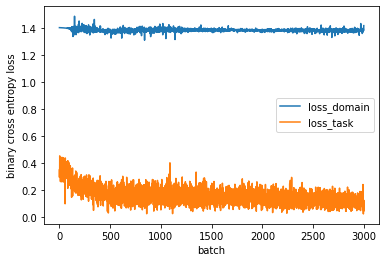

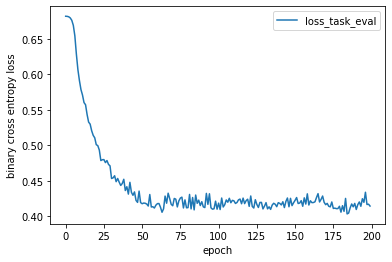

In [10]:
feature_extractor, task_classifier = utils.fit(source_loader, target_loader, test_target_X, test_target_y_task,
                                               feature_extractor, domain_classifier, task_classifier, criterion,
                                               feature_optimizer, domain_optimizer, task_optimizer, num_epochs=num_epochs, is_timeseries=False)

# Algo2. Psuedo Labeling

In [11]:
psuedo_labeler = utils.PsuedoLabeler() 
pred_y_task = task_classifier(feature_extractor(test_target_X))
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
psuedo_label = psuedo_labeler(pred_y_task)

In [12]:
print(psuedo_label)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.

# Algo3. Cross Season DA

## Prepare Data

In [13]:
train_source_X = target_X
train_source_y_task = psuedo_label

target_X = pd.read_csv(f"./deep_occupancy_detection/data/{TARGET_IDX}_X_train.csv")
target_y_task = pd.read_csv(f"./deep_occupancy_detection/data/{TARGET_IDX}_Y_train.csv")[target_X.Season==SUMMER_IDX].values.reshape(-1)
target_X = target_X[target_X.Season==SUMMER_IDX].values
target_X = scaler.fit_transform(target_X)

target_X, target_y_task = utils.apply_sliding_window(target_X, target_y_task, filter_len=3)
train_target_X, test_target_X, train_target_y_task, test_target_y_task = train_test_split(target_X, target_y_task, test_size=0.3, shuffle=False)

In [14]:
source_loader, target_loader, _, _, _, _ = utils.get_loader(train_source_X, train_target_X, train_source_y_task, train_target_y_task, shuffle=True)
# TODO: Update utils.get_loader's docstring

test_target_X = torch.tensor(test_target_X, dtype=torch.float32)
test_target_y_task = torch.tensor(test_target_y_task, dtype=torch.float32)
test_target_X = test_target_X.to(device)
test_target_y_task = test_target_y_task.to(device)

## Instantiate Feature Extractor, Domain Classifier, Task Classifier

In [15]:
feature_extractor = utils.ManyToOneRNN(input_size=train_source_X.shape[2], hidden_size=hidden_size, num_layers=3).to(device)

domain_classifier = utils.Decoder(input_size=hidden_size, output_size=num_domains).to(device)
task_classifier = utils.Decoder(input_size=hidden_size, output_size=num_classes).to(device)

In [16]:
learning_rate = 0.00005
feature_optimizer = optim.Adam(feature_extractor.parameters(), lr=learning_rate)
domain_optimizer = optim.Adam(domain_classifier.parameters(), lr=learning_rate)
task_optimizer = optim.Adam(task_classifier.parameters(), lr=learning_rate)

## Domain Invarinat Learning

In [17]:
num_epochs = 75

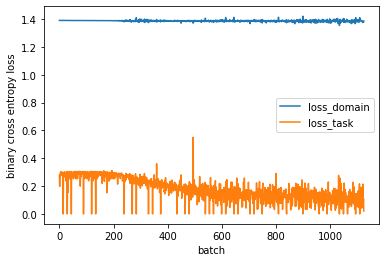

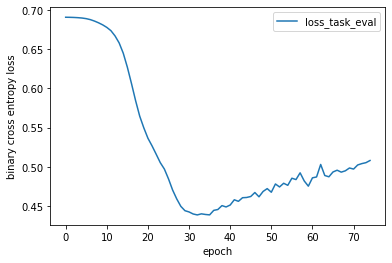

In [18]:
feature_extractor, task_classifier = utils.fit(source_loader, target_loader, test_target_X, test_target_y_task,
                                               feature_extractor, domain_classifier, task_classifier, criterion,
                                               feature_optimizer, domain_optimizer, task_optimizer, num_epochs=num_epochs, is_timeseries=False)

# Algo4. Evaluation

In [19]:
pred_y_task = task_classifier(feature_extractor(test_target_X))
pred_y_task = torch.sigmoid(pred_y_task).reshape(-1)
pred_y_task = pred_y_task > 0.5
acc = sum(pred_y_task == test_target_y_task) / test_target_y_task.shape[0]

In [20]:
print("Cross Domain, Cross Household Domain Adaptation Scores:")
print(classification_report(test_target_y_task.cpu().numpy(), pred_y_task.cpu().numpy()))

Cross Domain, Cross Household Domain Adaptation Scores:
              precision    recall  f1-score   support

         0.0       0.91      0.63      0.74       150
         1.0       0.75      0.95      0.84       176

    accuracy                           0.80       326
   macro avg       0.83      0.79      0.79       326
weighted avg       0.82      0.80      0.79       326

